<a href="https://colab.research.google.com/github/Sahilvohra58/food-vision-101-project/blob/main/Exp_08_Transfer_Learning_Fine_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
import tensorflow_datasets as tfds
import tensorflow as tf
datasets_list = tfds.list_builders() # get all available datasets in TFDS
print("food101" in datasets_list)
img_size = (224,224)

True


In [23]:
#pip install tensorflow==2.4.0

In [24]:
(train_data, test_data), ds_info = tfds.load(
    name= "food101",
    shuffle_files= True,
    split =["train", "validation"],
    download = True,
    data_dir = 'Data',
    as_supervised= True,
    with_info = True)

In [25]:
class_names = ds_info.features['label'].names

In [26]:
train_one_sample = train_data.take(1)
train_one_sample

<TakeDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

In [27]:
for img, lab in train_one_sample:
  print(img)
  print(lab)

tf.Tensor(
[[[ 19   6   0]
  [ 29  16   8]
  [ 34  21  13]
  ...
  [ 36  19   3]
  [ 35  19   3]
  [ 36  20   4]]

 [[ 20   7   0]
  [ 28  15   7]
  [ 34  21  13]
  ...
  [ 37  20   4]
  [ 37  20   4]
  [ 37  21   5]]

 [[ 20   7   0]
  [ 25  12   4]
  [ 31  18  10]
  ...
  [ 40  21   4]
  [ 40  21   4]
  [ 39  22   4]]

 ...

 [[208 206 194]
  [209 207 195]
  [211 209 197]
  ...
  [192 196 179]
  [190 194 177]
  [203 207 190]]

 [[208 206 194]
  [209 207 195]
  [210 208 196]
  ...
  [203 207 190]
  [211 214 197]
  [202 205 186]]

 [[208 206 194]
  [209 207 195]
  [210 208 196]
  ...
  [200 204 187]
  [201 204 185]
  [198 201 182]]], shape=(512, 512, 3), dtype=uint8)
tf.Tensor(65, shape=(), dtype=int64)


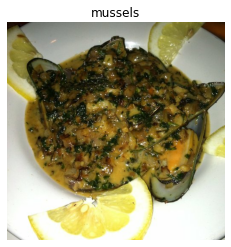

In [28]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plt.imshow(img.numpy())
plt.title(class_names[lab.numpy()])
plt.axis('off')
plt.show()

In [29]:
def preprocess_img(img, label):
  img = tf.image.resize(img, size = img_size)
  img = tf.cast(img, dtype = tf.float32)
  return img, label

In [30]:
test_data
#test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)

<_OptionsDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

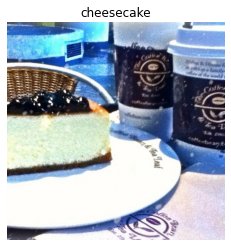

In [31]:
for img, lab in train_data.take(1):
  plt.imshow(img.numpy()/255.)
  plt.title(class_names[lab.numpy()])
  plt.axis('off')
  plt.show()

In [32]:
train_data = train_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
train_data = train_data.shuffle(buffer_size=10000).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

In [33]:
train_data

<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>

In [34]:
import datetime
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy="mixed_float16")

log_dir = "Tensorboard/Full-Data-Fine-Tuning/EfficientNet/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
callbacks = [
             #tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10 ** (epoch / 20), verbose=0),
             tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print out when learning rate goes down 
                                                 min_lr=1e-7),
              tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                              patience=5, 
                                              verbose=0),
              tf.keras.callbacks.ModelCheckpoint(
                  filepath='Models_checkpoint_EfficientNet_Full_Data_Fine_Tuning/model_ep_{epoch:02d}_val_accuracy_{val_accuracy:.4f}.ckpt',
                  # file path format: "Model_checkpoint_Classification_2/cp-{epoch:02d}-{val_loss:.02f}.ckpt"
                  save_weights_only=True,
                  verbose=0),
            tf.keras.callbacks.TensorBoard(log_dir=log_dir)
                ]

mixed_precision.global_policy()

<Policy "mixed_float16">

In [35]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create base model
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False # freeze base model layers

# Create Functional model 
inputs = layers.Input(shape=img_size+(3,), name="input_layer")
# Note: EfficientNetBX models have rescaling built-in but if your model didn't you could have a layer like below
# x = preprocessing.Rescaling(1./255)(x)
x = base_model(inputs, training=False) # set base_model to inference mode only
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dense(len(class_names))(x) # want one output neuron per class 
# Separate activation of output layer so we can output float32 activations
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x) 
model = tf.keras.Model(inputs, outputs)



In [36]:
#!wget https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_feature_extract_model_mixed_precision.zip 
#!mkdir downloaded_gs_model # create new dir to store downloaded feature extraction model
#!unzip 07_efficientnetb0_feature_extract_model_mixed_precision.zip -d downloaded_gs_model
loaded_gs_model = tf.keras.models.load_model("/content/downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision")

--2021-12-02 19:29:18--  https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_feature_extract_model_mixed_precision.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.5.128, 74.125.133.128, 108.177.15.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.5.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16976857 (16M) [application/zip]
Saving to: ‘07_efficientnetb0_feature_extract_model_mixed_precision.zip.1’

07_efficientnetb0_f 100%[===================>]  16.19M  --.-KB/s    in 0.1s    

2021-12-02 19:29:19 (138 MB/s) - ‘07_efficientnetb0_feature_extract_model_mixed_precision.zip.1’ saved [16976857/16976857]

mkdir: cannot create directory ‘downloaded_gs_model’: File exists
Archive:  07_efficientnetb0_feature_extract_model_mixed_precision.zip
replace downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/variables/variables.data-00000-of-00001? [y]es, [n]o, [A]ll, [

In [37]:
results_loaded_gs_model = loaded_gs_model.evaluate(test_data)

790/790 [==============================] - 79s 97ms/step - loss: 1.0881 - accuracy: 0.7065


In [38]:
for layer in loaded_gs_model.layers:
  layer.trainable = True
  print(layer.trainable)

True
True
True
True
True


In [39]:
# Compile the model
loaded_gs_model.compile(loss="sparse_categorical_crossentropy", # Use sparse_categorical_crossentropy when labels are *not* one-hot
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [40]:
history_101_food_classes_all_data_fine_tune = loaded_gs_model.fit(train_data,
                                                        epochs=100, # fine-tune for a maximum of 100 epochs
                                                        steps_per_epoch=len(train_data),
                                                        validation_data=test_data,
                                                        validation_steps=int(0.15 * len(test_data)), # validation during training on 15% of test data
                                                        callbacks=callbacks)

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/100
2368/2368 [==============================] - 1184s 484ms/step - loss: 1.5906 - accuracy: 0.5913 - val_loss: 1.1210 - val_accuracy: 0.6949 - lr: 0.0010
Epoch 2/100
2368/2368 [==============================] - 1150s 477ms/step - loss: 1.1903 - accuracy: 0.6838 - val_loss: 1.0869 - val_accuracy: 0.7084 - lr: 0.0010
Epoch 3/100
2368/2368 [==============================] - 1149s 476ms/step - loss: 1.0171 - accuracy: 0.7241 - val_loss: 0.9792 - val_accuracy: 0.7383 - lr: 0.0010
Epoch 4/100
2368/2368 [==============================] - 1145s 474ms/step - loss: 1.0018 - accuracy: 0.7375 - val_loss: 1.3461 - val_accuracy: 0.6454 - lr: 0.0010
Epoch 5/100
2368/2368 [==============================] - ETA: 0s - loss: nan - accuracy: 0.6373
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
2368/2368 [==============================] - 1153s 478ms/step - loss: nan - accuracy: 0.6373 - val_loss: nan - val_accuracy: 0.0077 - lr: 0.0010
Epoch 6/100
2368/2368 [===

In [41]:
from google.colab import files
import os

dir_to_zip = '/content/Models_checkpoint_EfficientNet_Full_Data_Fine_Tuning' #@param {type: "string"}
output_filename = 'Models_checkpoint_EfficientNet_Full_Data_Fine_Tuning.zip' #@param {type: "string"}
delete_dir_after_download = "No"  #@param ['Yes', 'No']

os.system( "zip -r {} {}".format( output_filename , dir_to_zip ) )

if delete_dir_after_download == "Yes":
    os.system( "rm -r {}".format( dir_to_zip ) )

files.download( output_filename )

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [42]:
from google.colab import files
import os

dir_to_zip = '/content/Tensorboard' #@param {type: "string"}
output_filename = 'Tensorboard.zip' #@param {type: "string"}
delete_dir_after_download = "No"  #@param ['Yes', 'No']

os.system( "zip -r {} {}".format( output_filename , dir_to_zip ) )

if delete_dir_after_download == "Yes":
    os.system( "rm -r {}".format( dir_to_zip ) )

files.download( output_filename )

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [49]:
best_model = tf.keras.models.load_model('/content/Models_checkpoint_EfficientNet_Full_Data_Fine_Tuning/model_ep_03_val_accuracy_0.7383.ckpt.data-00000-of-00001')

OSError: ignored